In [1]:
import numpy as np 
from numpy.linalg import qr, svd

from scipy.integrate import solve_ivp
from scipy.linalg import hadamard, subspace_angles

import math

import jax
import jax.numpy as jnp
from jax import grad, random, vmap
import optax

from linear_sca import *
from utils import *

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
from sklearn.linear_model import ElasticNetCV, LinearRegression, RidgeCV

import wandb

In [2]:
path = "/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/psth.npy"

X_raw = np.load(path).swapaxes(1,2)
print(X_raw.shape)
K, N, T = X_raw.shape

X, _ = pre_processing(X_raw, soft_normalize='max')
X_pre_pca, _ = pre_processing(X_raw, soft_normalize='max', pca=False)

(108, 182, 140)


In [3]:
np.mean(compute_S(X))

0.4347857

In [24]:
d=2
wandb.init(project="SCA-project-MC_Maze", name=f"d={d}", mode="disabled")
U, ls_loss, ls_S_ratio = optimize(X,d=d, iterations=5000, seed=43) 
wandb.finish()
#np.save(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/linear_sca/MC_Maze/2_6_2024/single spikes/U_psth_{d}d', U)

Iteration 0, S: 0.3263087868690491, S_ratio: 0.10488656908273697
Iteration 10, S: 0.20324347913265228, S_ratio: 0.08170779049396515
Iteration 20, S: 0.2997031807899475, S_ratio: 0.06990979611873627
Iteration 30, S: 0.24813592433929443, S_ratio: 0.0877353772521019
Iteration 40, S: 0.34042003750801086, S_ratio: 0.1659272164106369
Iteration 50, S: 0.48939481377601624, S_ratio: 0.13236357271671295
Iteration 60, S: 0.306599885225296, S_ratio: 0.10186217725276947
Iteration 70, S: 0.5632581114768982, S_ratio: 0.12047577649354935
Iteration 80, S: 0.9314014315605164, S_ratio: 0.2512021064758301
Iteration 90, S: 0.993535041809082, S_ratio: 0.1441577821969986
Iteration 100, S: 0.6672081351280212, S_ratio: 0.2056981772184372
Iteration 110, S: 0.710735559463501, S_ratio: 0.12882737815380096
Iteration 120, S: 1.0101912021636963, S_ratio: 0.19165046513080597
Iteration 130, S: 0.5467836856842041, S_ratio: 0.13204996287822723
Iteration 140, S: 1.346020221710205, S_ratio: 0.1729033887386322
Iteration 15

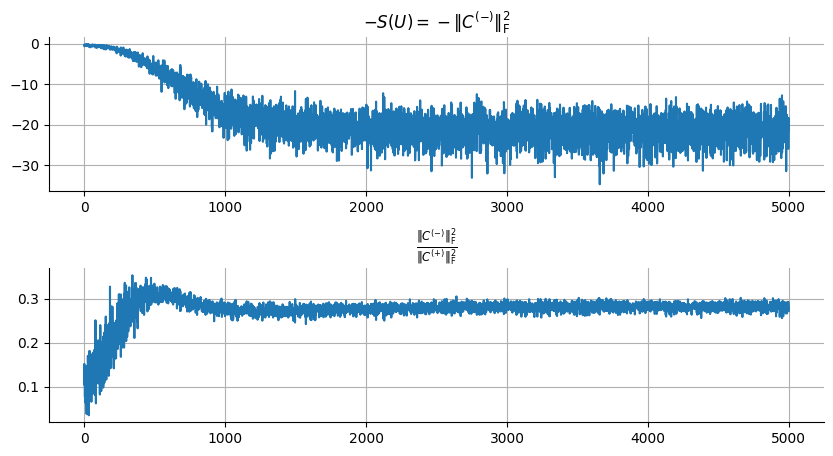

In [25]:
plt.figure(figsize=(10,5))
plt.subplot(211)
plt.plot(ls_loss)
plt.grid()
plt.title(r"$-S(U) = -\|C^{(-)}\|_\mathrm{F}^2$")
plt.gca().spines[['top','right']].set_visible(False)
plt.subplot(212)
plt.plot(ls_S_ratio)
plt.title(r"$\frac{\|C^{(-)}\|_\mathrm{F}^2}{\|C^{(+)}\|_\mathrm{F}^2}$")
plt.gca().spines[['top','right']].set_visible(False)
plt.grid()
plt.subplots_adjust(hspace=0.5)

Text(0.5, 1.0, 'sca 0.22')

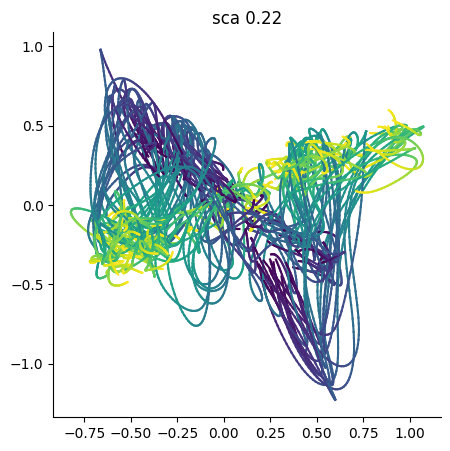

In [28]:
#X= np.load("/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/outputs_cluster/MC_Maze/test/test/X_3d.npy")
U = np.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/linear_sca/MC_Maze/3_6_2024/seed_43/U_psth_2d.npy')

U_qr, _ = jnp.linalg.qr(U)        
Y = jnp.einsum('ji,kjl->kil', U_qr, X)
idx = [2,4]
plot_2D(Y[:,:,:])
plt.title(f"sca {var_explained(X, U_qr):.2f}")
#np.mean(compute_S(jnp.array(Y)))

0.27875167


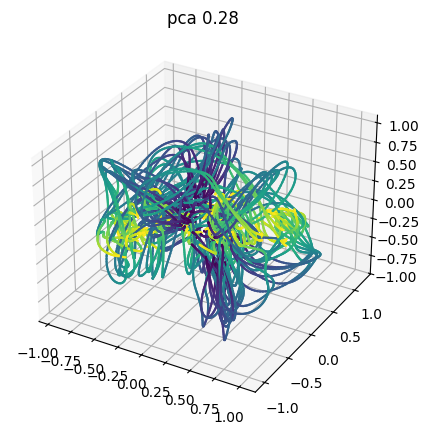

In [10]:
""" PCA """
X_reshaped = np.concatenate(X_pre_pca.swapaxes(1,2))

num_pcs = 3
pca = PCA(num_pcs)
X_pca = pca.fit_transform(X_reshaped)
PCs = pca.components_
X_pca = X_pca.reshape(K, T, num_pcs).swapaxes(1,2)
pca_variance_captured = pca.explained_variance_ratio_

plot_3D(X_pca)
plt.title(f"pca {var_explained(X_pre_pca, PCs.T):.2f}")

print(np.sum(pca_variance_captured))

#print(np.mean(compute_S(jnp.array(X_pca))))
#print(np.mean(compute_S(jnp.array(X_pca), ratio=False )))
#np.save(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/linear_sca/MC_Maze/2_6_2024/single spikes/pca_variance_captured_{num_pcs}d', pca_variance_captured)
#np.save(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/linear_sca/MC_Maze/2_6_2024/single spikes/PCs_{num_pcs}d', PCs)
#np.save(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/linear_sca/MC_Maze/2_6_2024/single spikes/X_pca_{num_pcs}d', X_pca)

In [3]:
hand_vel = np.load("/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/train_eval_behaviour_grouped.npy").swapaxes(1,2)

In [4]:
def get_reg(X_train,y_train,X_test, y_test):
    regr = RidgeCV()
    reg = regr.fit(X_train, y_train)   
    return reg.score(X_test, y_test)   

def principal_angle(Y, X_pca, d, smaller=True):
    Q_A, _ = qr(Y.swapaxes(1,2).reshape(-1,d), mode='reduced')
    Q_B, _ = qr(X_pca.swapaxes(1,2).reshape(-1,d), mode='reduced')
        
    M = np.dot(Q_A.T, Q_B)
        
    _, singular_values, _ = svd(M)
    
    angles = np.arccos(singular_values)
    angles = np.rad2deg(np.sort(angles)[::-1])
    
    if smaller:
        return angles[-1]
    else:
        return angles

In [17]:
ds = np.arange(2,11)

split = 10
lag = 20

ls_r2_sca = []
ls_r2_pca = []
ls_r2_x = []

ls_var_sca = []
#ls_var_pca = []
ls_var_pca = np.cumsum(np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/linear_sca/MC_Maze/3_6_2024/seed_42/pca_variance_captured_10d.npy'))[1:]

ls_S_sca = []
ls_S_pca = []

ls_S_numerator_sca = []
ls_S_numerator_pca = []

ls_principal_angle = []
for d in ds:
    y_train = np.concatenate(hand_vel[split:,:,lag:].swapaxes(1,2))
    y_test = np.concatenate(hand_vel[:split,:,lag:].swapaxes(1,2))
    
    U = np.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/linear_sca/MC_Maze/3_6_2024/seed_43/U_psth_{d}d.npy')
    U_qr, _ = jnp.linalg.qr(U)        
    Y = jnp.einsum('ji,kjl->kil', U_qr, X)
    
    X_train_sca = np.concatenate(Y[split:,:,:-lag].swapaxes(1,2))
    X_test_sca = np.concatenate(Y[:split,:,:-lag].swapaxes(1,2))
    ls_r2_sca.append( get_reg(X_train_sca,y_train,X_test_sca, y_test) )
    
    ls_var_sca.append( var_explained(X, U_qr) ) 
    
    ls_S_sca.append( np.mean(compute_S(jnp.array(Y))))
    ls_S_numerator_sca.append(np.mean(compute_S(jnp.array(Y), ratio=False )))

    X_pca = np.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/linear_sca/MC_Maze/3_6_2024/seed_42/X_pca_{d}d.npy')
    PCs = np.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/linear_sca/MC_Maze/3_6_2024/seed_42/PCs_{d}d.npy')
    
    X_train_pca = np.concatenate(X_pca[split:,:,:-lag].swapaxes(1,2))
    X_test_pca = np.concatenate(X_pca[:split,:,:-lag].swapaxes(1,2))
    ls_r2_pca.append( get_reg(X_train_pca,y_train,X_test_pca, y_test) ) 

   # ls_var_pca.append( var_explained(X_pre_pca, PCs.T) ) 
    
    ls_S_pca.append( np.mean(compute_S(jnp.array(X_pca))))
    ls_S_numerator_pca.append(np.mean(compute_S(jnp.array(X_pca), ratio=False )))

    # Q_Y, _ = qr(Y.swapaxes(1,2).reshape(-1,d))
    # Q_X_pca, _ = qr(X_pca.swapaxes(1,2).reshape(-1,d))
    # ls_principal_angle.append( np.rad2deg(subspace_angles(Q_Y, Q_X_pca))[-1] )

    Q_U, _ = qr(U.T)
    Q_PC, _ = qr(PCs)
    ls_principal_angle.append( np.rad2deg(subspace_angles(Q_U, Q_PC))[-1] )

X_train = np.concatenate(X[split:,:,:-lag].swapaxes(1,2))
X_test = np.concatenate(X[:split,:,:-lag].swapaxes(1,2))
r2_x = get_reg(X_train,y_train,X_test, y_test) 

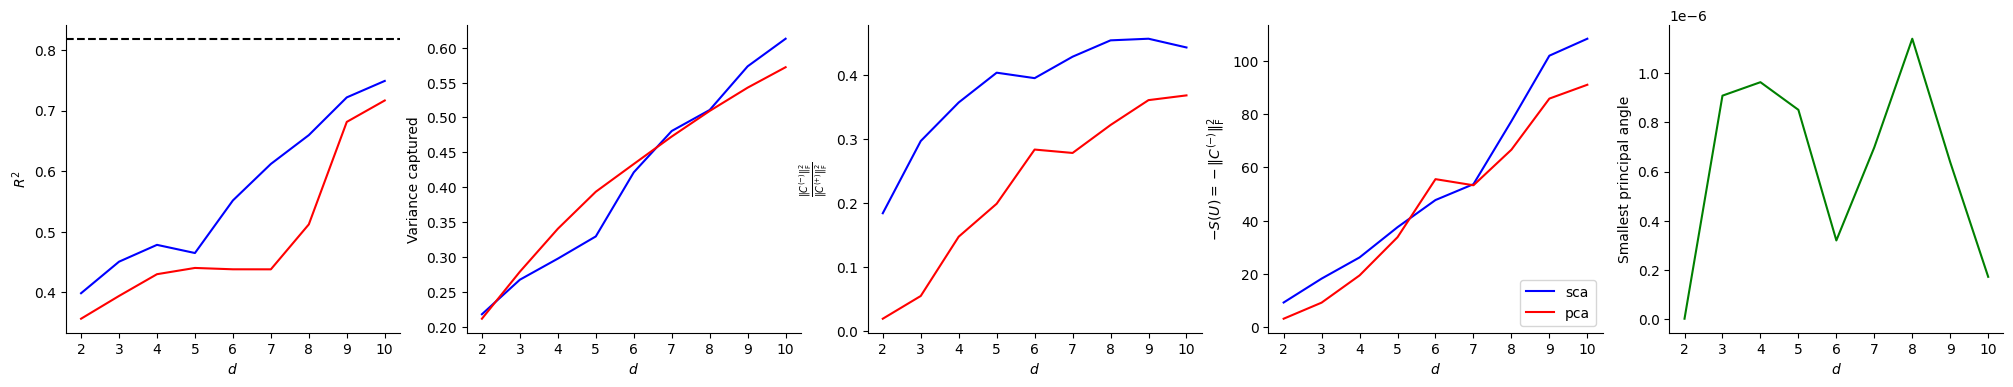

In [18]:
fig, axs = plt.subplots(1,5, figsize=(25,4))

#plt.grid(True)
axs[0].plot(ls_r2_sca, label='sca',color='b')
axs[0].plot(ls_r2_pca, label='pca',color='r')
axs[0].axhline(r2_x, color='black',linestyle='--', label='x')
axs[0].set_xlabel(r"$d$")
axs[0].set_ylabel(r"$R^2$")


axs[1].plot(ls_var_sca, label='sca', color='b')
axs[1].plot(ls_var_pca, label='pca',color='r')
axs[1].set_xlabel(r'$d$')
axs[1].set_ylabel('Variance captured')

axs[2].plot(ls_S_sca, label='sca', color='b')
axs[2].plot(ls_S_pca, label='pca',color='r')
axs[2].set_xlabel(r'$d$')
axs[2].set_ylabel((r"$\frac{\|C^{(-)}\|_\mathrm{F}^2}{\|C^{(+)}\|_\mathrm{F}^2}$"))


axs[3].plot(ls_S_numerator_sca, label='sca', color='b')
axs[3].plot(ls_S_numerator_pca, label='pca',color='r')
axs[3].legend(loc='lower right')
axs[3].set_xlabel(r'$d$')
axs[3].set_ylabel(r"$-S(U) = -\|C^{(-)}\|_\mathrm{F}^2$")

axs[4].plot(ls_principal_angle, color='g')
axs[4].set_xlabel(r'$d$')
axs[4].set_ylabel('Smallest principal angle')

data_length = len(ls_r2_sca) 
tick_positions = np.linspace(0, data_length - 1, num=9) 
tick_labels = np.arange(2, 11) 
for ax in axs:
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xticks(tick_positions, tick_labels)
    #ax.grid()
    


In [14]:
split=10
lag = 20
X_train = np.concatenate(Y[split:,:,:-lag].swapaxes(1,2))
X_test = np.concatenate(Y[:split,:,:-lag].swapaxes(1,2))

y_train = np.concatenate(hand_vel[split:,:,lag:].swapaxes(1,2))
y_test = np.concatenate(hand_vel[:split,:,lag:].swapaxes(1,2))

get_reg(X_train,y_train,X_test, y_test)

0.45298923752338416

In [15]:
X_train = np.concatenate(X_pca[split:,:,:-lag].swapaxes(1,2))
X_test = np.concatenate(X_pca[:split,:,:-lag].swapaxes(1,2))

get_reg(X_train,y_train,X_test, y_test)

0.39411666469981244

In [16]:
X_train = np.concatenate(X[split:,:,:-lag].swapaxes(1,2))
X_test = np.concatenate(X[:split,:,:-lag].swapaxes(1,2))

get_reg(X_train,y_train,X_test, y_test)

0.8178163161582568

FOR ALL SEEDS

In [59]:
import os 
def main_processing(folder_path, X_pca, d, split=10, lag=20):
    # Initialize lists to store results
    ls_r2 = []
    ls_var = []
    ls_S = []
    ls_S_numerator = []
    ls_principal_angle = []
    
    # Loop through each seed folder
    for seed_folder in sorted(os.listdir(folder_path)):
        if seed_folder.startswith('seed_'):

            U = np.load(os.path.join(folder_path, seed_folder, f'U_psth_{d}d.npy'))
            U_qr, _ = jnp.linalg.qr(U)

            y_train = np.concatenate(hand_vel[split:, :, lag:].swapaxes(1, 2))
            y_test = np.concatenate(hand_vel[:split:, :, lag:].swapaxes(1, 2))
            Y = jnp.einsum('ji,kjl->kil', U_qr, X)
            
            X_train_sca = np.concatenate(Y[split:, :, :-lag].swapaxes(1, 2))
            X_test_sca = np.concatenate(Y[:split, :, :-lag].swapaxes(1, 2))

            ls_r2.append(get_reg(X_train_sca, y_train, X_test_sca, y_test))
            ls_var.append(var_explained(X, U_qr))
            ls_S.append(np.mean(compute_S(jnp.array(Y))))
            ls_S_numerator.append(np.mean(compute_S(jnp.array(Y), ratio=False)))

            Q_Y, _ = qr(Y.swapaxes(1,2).reshape(-1,d))
            Q_X_pca, _ = qr(X_pca.swapaxes(1,2).reshape(-1,d))
            ls_principal_angle.append( np.rad2deg(subspace_angles(Q_Y, Q_X_pca))[-1] )

    mean_r2 = np.mean(ls_r2)
    std_r2 = np.std(ls_r2)
    mean_var = np.mean(ls_var)
    std_var = np.std(ls_var)
    mean_S = np.mean(ls_S)
    std_S = np.std(ls_S)
    mean_S_numerator = np.mean(ls_S_numerator)
    std_S_numerator = np.std(ls_S_numerator)
    mean_principal_angle = np.mean(ls_principal_angle)
    std_principal_angle = np.std(ls_principal_angle)
    print(f'd={d}: ls_r2={ls_r2}')
    return mean_r2, std_r2, mean_var, std_var, mean_S, std_S, mean_S_numerator, std_S_numerator, mean_principal_angle, std_principal_angle


ds = np.arange(2,11)

split = 10
lag = 20

ls_r2_sca = []
ls_r2_sca_std = []
ls_r2_pca = []
ls_r2_x = []

ls_var_sca = []
ls_var_sca_std = []
#ls_var_pca = []
ls_var_pca = np.cumsum(np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/linear_sca/MC_Maze/3_6_2024/seed_42/pca_variance_captured_10d.npy'))[1:]

ls_S_sca = []
ls_S_sca_std = []
ls_S_pca = []

ls_S_numerator_sca = []
ls_S_numerator_sca_std = []
ls_S_numerator_pca = []

ls_principal_angle = []
ls_principal_angle_std = []
for d in ds:
    y_train = np.concatenate(hand_vel[split:,:,lag:].swapaxes(1,2))
    y_test = np.concatenate(hand_vel[:split,:,lag:].swapaxes(1,2))

    X_pca = np.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/linear_sca/MC_Maze/3_6_2024/seed_42/X_pca_{d}d.npy')
    
    X_train_pca = np.concatenate(X_pca[split:,:,:-lag].swapaxes(1,2))
    X_test_pca = np.concatenate(X_pca[:split,:,:-lag].swapaxes(1,2))
    ls_r2_pca.append( get_reg(X_train_pca,y_train,X_test_pca, y_test) ) 
    
    ls_S_pca.append( np.mean(compute_S(jnp.array(X_pca))))
    ls_S_numerator_pca.append(np.mean(compute_S(jnp.array(X_pca), ratio=False )))

    mean_r2, std_r2, mean_var, std_var, mean_S, std_S, mean_S_numerator, std_S_numerator, mean_principal_angle, std_principal_angle = main_processing('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/linear_sca/MC_Maze/3_6_2024',X_pca, d)
    
    ls_r2_sca.append( mean_r2 )
    ls_r2_sca_std.append( std_r2 )
    
    ls_var_sca.append( mean_var ) 
    ls_var_sca_std.append( std_var ) 
    
    ls_S_sca.append( mean_S)
    ls_S_sca_std.append( std_S)

    ls_S_numerator_sca.append( mean_S_numerator)
    ls_S_numerator_sca_std.append( std_S_numerator)

    ls_principal_angle.append( mean_principal_angle )
    ls_principal_angle_std.append( std_principal_angle )

X_train = np.concatenate(X[split:,:,:-lag].swapaxes(1,2))
X_test = np.concatenate(X[:split,:,:-lag].swapaxes(1,2))
r2_x = get_reg(X_train,y_train,X_test, y_test) 

d=2: ls_r2=[0.400453746370985, 0.3991076012725949, 0.3993632553532145]
d=3: ls_r2=[0.45219213950185183, 0.4521506564904827, 0.451287124326199]
d=4: ls_r2=[0.4793804613759817, 0.4905115413477946, 0.47890809533185935]
d=5: ls_r2=[0.46549168729308577, 0.4819571325098487, 0.46563864207885697]
d=6: ls_r2=[0.5175965047410458, 0.5367030041319538, 0.5514373477540264]
d=7: ls_r2=[0.603879024450257, 0.63630643112684, 0.6124131383151477]
d=8: ls_r2=[0.6493406785703038, 0.7034129865336505, 0.6603417938620165]
d=9: ls_r2=[0.7493014025610465, 0.7373555526832203, 0.722607398032676]
d=10: ls_r2=[0.7505800160837762, 0.7360332770254304, 0.74885619883727]


In [41]:
def get_mean_std_plot(ax, x_axis, means, std, color='b'):
    ax.plot(x_axis, np.array(means), label='sca',color=color)
    ax.fill_between(x_axis, np.array(means) - np.array(std),np.array(means) + np.array(std), alpha=0.1, color=color)


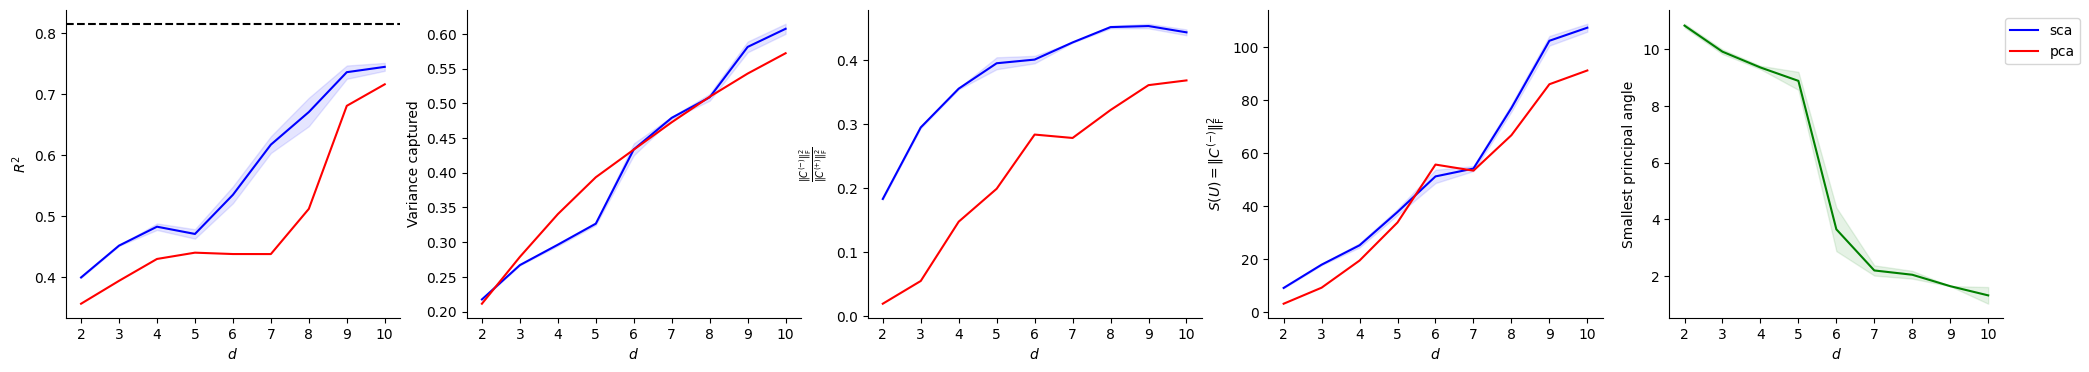

In [60]:
fig, axs = plt.subplots(1,5, figsize=(25,4))

#plt.grid(True)
x_axis = np.arange(0, 9) 
get_mean_std_plot(axs[0], x_axis, ls_r2_sca, ls_r2_sca_std)


axs[0].plot(ls_r2_pca, label='pca',color='r')
axs[0].axhline(r2_x, color='black',linestyle='--', label='x')
axs[0].set_xlabel(r"$d$")
axs[0].set_ylabel(r"$R^2$")


get_mean_std_plot(axs[1], x_axis, ls_var_sca, ls_var_sca_std)
axs[1].plot(ls_var_pca, label='pca',color='r')
axs[1].set_xlabel(r'$d$')
axs[1].set_ylabel('Variance captured')

get_mean_std_plot(axs[2], x_axis, ls_S_sca, ls_S_sca_std)
axs[2].plot(ls_S_pca, label='pca',color='r')
axs[2].set_xlabel(r'$d$')
axs[2].set_ylabel((r"$\frac{\|C^{(-)}\|_\mathrm{F}^2}{\|C^{(+)}\|_\mathrm{F}^2}$"))


get_mean_std_plot(axs[3], x_axis, ls_S_numerator_sca, ls_S_numerator_sca_std)
axs[3].plot(ls_S_numerator_pca, label='pca',color='r')
axs[3].set_xlabel(r'$d$')
axs[3].set_ylabel(r"$S(U) = \|C^{(-)}\|_\mathrm{F}^2$")
axs[3].legend(bbox_to_anchor=[2.45,0.8], loc='lower right')

get_mean_std_plot(axs[4], x_axis, ls_principal_angle, ls_principal_angle_std, color='g')
axs[4].set_xlabel(r'$d$')
axs[4].set_ylabel('Smallest principal angle')


data_length = len(ls_r2_sca) 
tick_positions = np.linspace(0, data_length - 1, num=9) 
tick_labels = np.arange(2, 11) 
for ax in axs:
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xticks(tick_positions, tick_labels)
    #ax.grid()

ENDS HERE 

In [13]:
d=3
X, _ = pre_processing(X_raw, soft_normalize='max')
U = np.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/linear_sca/MC_Maze/2_6_2024/all/U_psth_3d.npy')
U_qr, _ = jnp.linalg.qr(U)        
Y = jnp.einsum('ji,kjl->kil', U_qr, X)
print(np.mean(compute_S(Y)))

Q_A, _ = qr(Y.swapaxes(1,2).reshape(-1,d), mode='reduced')
Q_B, _ = qr(X_pca.swapaxes(1,2).reshape(-1,d), mode='reduced')
    
M = np.dot(Q_A.T, Q_B)
    
_, singular_values, _ = svd(M)
   
angles = np.arccos(singular_values)
   
np.rad2deg(np.sort(angles)[::-1]  )

0.2927623


array([79.181206, 34.42475 ,  9.955877], dtype=float32)

In [34]:
X, _ = pre_processing(X_raw, soft_normalize='max', pca=True)
d = 10
U = np.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/SCA_project/outputs/linear_sca/MC_Maze/U_psth_0.001_10000_3d.npy')
U_qr, _ = jnp.linalg.qr(U)        
Y = jnp.einsum('ji,kjl->kil', U_qr, X)
X_pca = np.load(f'/Users/ariellerosinski/My Drive/Cambridge/Project/SCA_project/outputs/linear_sca/MC_Maze/29_5_2024/X_pca_10d.npy')

Q_A, _ = qr(Y.swapaxes(1,2).reshape(-1,d))
Q_B, _ = qr(X_pca.swapaxes(1,2).reshape(-1,d))
np.rad2deg( subspace_angles(Q_A, Q_B) )

array([86.69891  , 50.686737 , 30.592262 , 18.307602 , 11.221379 ,
        6.564292 ,  6.0623813,  3.420586 ,  2.2835336,  1.305213 ],
      dtype=float32)